# Abstract: 

There has been a sudden increase in the use of Deep Learning in tasks ranging from image classification to generating complex models like GPT 3. One of the most common things with the Machine Learning or Deep Learning pipeline is that the entire process is done on the same server. The training, testing, and validation data are on the same machine. In this post, we are going to talk about how decentralized training of deep learning models takes place and what are the advantages associated with this approach. We are using the TensorFlow-Federated framework along with the MNIST dataset to show the working of Federated Learning. We also analyze the model accuracy and processing time for each iteration with the number of clients present in the system.

# Loading Libraries

In [ ]:
!pip install --quiet --upgrade tensorflow-federated==0.20.0
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

     |████████████████████████████████| 819 kB 5.4 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 251 kB 45.3 MB/s 
     |████████████████████████████████| 121 kB 43.8 MB/s 
     |████████████████████████████████| 4.0 MB 36.4 MB/s 
     |████████████████████████████████| 887 kB 43.9 MB/s 
     |████████████████████████████████| 237 kB 38.5 MB/s 
     |████████████████████████████████| 65.1 MB 88 kB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 462 kB 44.9 MB/s 
     |████████████████████████████████| 4.2 MB 32.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
pymc3 3.11.4 requires cachetools>=4.2.1, but you have cachetools 3.1.1 which is incompatible.
panel 0.1

In [ ]:
%load_ext tensorboard

In [ ]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

# Load Data

In [ ]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
print(len(emnist_train.client_ids))
print(emnist_train.element_type_structure)

3383
OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])


# Visualization of Data

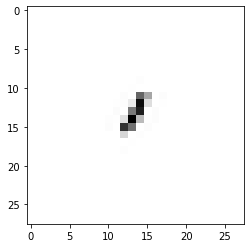

In [ ]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

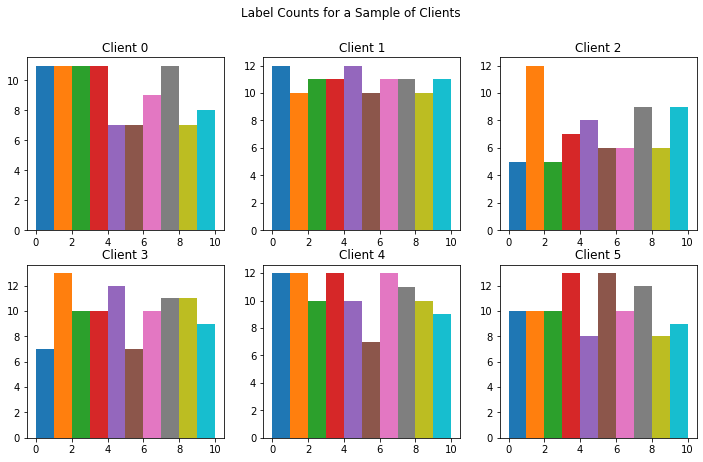

In [ ]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Pre-Process

In [ ]:
NUM_CLIENTS = 5
NUM_EPOCHS = 200
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [ ]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[2],
                     [1],
                     [5],
                     [7],
                     [1],
                     [7],
                     [7],
                     [1],
                     [4],
                     [7],
                     [4],
                     [2],
                     [2],
                     [5],
                     [4],
                     [1],
                     [1],
                     [0],
                     [0],
                     [9]], dtype=int32))])

In [ ]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [ ]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 5
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


# model with Keras

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def create_keras_model():
  model = keras.Sequential(
    [
        keras.Input(shape=(784,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

  return model

In [ ]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
None


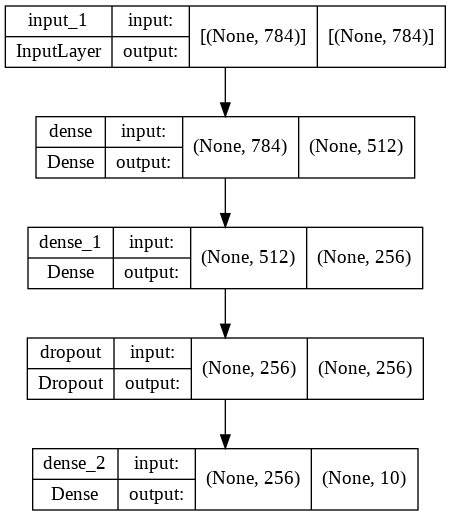

In [ ]:
from keras.utils.vis_utils import plot_model
keras_model = create_keras_model()
print(keras_model.summary())
plot_model(keras_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training the model on federated data

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [ ]:
state = iterative_process.initialize()

In [ ]:
NUM_ROUNDS = 200
train_accuracy = []
test_accuracy = []
train_loss=[]
test_loss=[]

for round_num in range(1, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)

  tuple_list = list(metrics.items())
  temp = tuple_list[2][1]
  temp1= list(temp.items())
  train_accuracy.append(temp1[0][1])
  train_loss.append(temp1[1][1])

  print('round {:2d}, metrics={}'.format(round_num, metrics))



round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.12083333), ('loss', 2.4941545), ('num_examples', 2400), ('num_batches', 123)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.14458333), ('loss', 2.2799745), ('num_examples', 2400), ('num_batches', 123)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.16583334), ('loss', 2.252829), ('num_examples', 2400), ('num_batches', 123)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.19166666), ('loss', 2.222153), ('nu

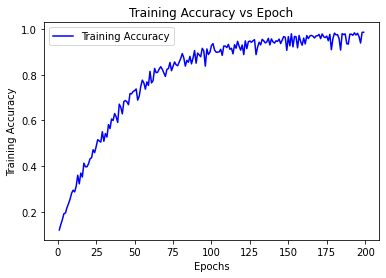

In [ ]:
train_accuracy_plot = train_accuracy
test_accuracy_plot = test_accuracy

epochs = range(1,200)

plt.plot(epochs, train_accuracy_plot, 'b', label='Training Accuracy')
#plt.plot(epochs, test_accuracy_plot, 'b', label='Testing Accuracy')
plt.title('Training Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

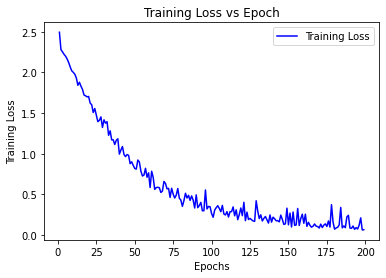

In [ ]:
train_loss_plot = train_loss
test_loss_plot = test_loss

epochs = range(1,200)

plt.plot(epochs, train_loss_plot, 'b', label='Training Loss')
#plt.plot(epochs, test_loss_plot, 'b', label='Testing Loss')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Eval

In [ ]:
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
train_metrics = evaluation(state.model, federated_train_data)

In [ ]:
str(train_metrics)

"OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.97083336), ('loss', 0.07591665), ('num_examples', 2400), ('num_batches', 123)]))])"

In [ ]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(5,
 <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>)

In [ ]:
test_metrics = evaluation(state.model, federated_test_data)

In [ ]:
str(test_metrics)

"OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9122807), ('loss', 0.46260446), ('num_examples', 285), ('num_batches', 16)]))])"

# experimentations


In [ ]:
#NUM_CLIENTS = 4
client_list_custom=[2,4,5,6,8,10]

for cli_list in client_list_custom:
  print("Number of clients: ",cli_list)
  NUM_CLIENTS=cli_list  
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
  example_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[0])

  example_element = next(iter(example_dataset))


  NUM_EPOCHS = 26
  BATCH_SIZE = 20
  SHUFFLE_BUFFER = 100
  PREFETCH_BUFFER = 10

  def preprocess(dataset):

    def batch_format_fn(element):
      return collections.OrderedDict(
          x=tf.reshape(element['pixels'], [-1, 784]),
          y=tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

  preprocessed_example_dataset = preprocess(example_dataset)

  sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_example_dataset)))

  def make_federated_data(client_data, client_ids):
    return [
        preprocess(client_data.create_tf_dataset_for_client(x))
        for x in client_ids
    ]


  sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

  federated_train_data = make_federated_data(emnist_train, sample_clients)


  from tensorflow import keras
  from tensorflow.keras import layers

  def create_keras_model():
    model = keras.Sequential(
      [
          keras.Input(shape=(784,)),
          layers.Dense(512, activation='relu'),
          layers.Dense(256, activation='relu'),
          layers.Dropout(0.5),
          layers.Dense(10, activation="softmax"),
      ]
  )

    return model


  def model_fn():
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=preprocessed_example_dataset.element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])  
    
  from keras.utils.vis_utils import plot_model
  keras_model = create_keras_model()

  iterative_process = tff.learning.build_federated_averaging_process(
      model_fn,
      client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
      server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

  state = iterative_process.initialize()

  train_accuracy = []
  test_accuracy = []
  train_loss=[]
  test_loss=[]
  import time

  start = time.time()
  for round_num in range(1, NUM_EPOCHS):
    state, metrics = iterative_process.next(state, federated_train_data)

    tuple_list = list(metrics.items())
    temp = tuple_list[2][1]
    temp1= list(temp.items())
    train_accuracy.append(temp1[0][1])
    train_loss.append(temp1[1][1])
    if(round_num%5==0):
      print('--->round {:2d}, metrics={}'.format(round_num, metrics))
      if(cli_list==5 or cli_list==10):
        evaluation = tff.learning.build_federated_evaluation(model_fn)
        federated_test_data = make_federated_data(emnist_test, sample_clients)
        test_metrics = evaluation(state.model, federated_test_data)
        print("Testing accuracy")
        print(str(test_metrics))

  end=time.time()
  print("avg time for 1 epochs:",str((end-start)/25))

  evaluation = tff.learning.build_federated_evaluation(model_fn)
  federated_test_data = make_federated_data(emnist_test, sample_clients)
  test_metrics = evaluation(state.model, federated_test_data)
  print("Testing accuracy")
  print(str(test_metrics))
  print("-------------------------------------")

Number of clients:  2
--->round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.46249047), ('loss', 1.5535946), ('num_examples', 5252), ('num_batches', 263)]))])
--->round 10, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7298172), ('loss', 0.8447138), ('num_examples', 5252), ('num_batches', 263)]))])
--->round 15, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.90746385), ('loss', 0.34925738), ('num_examples', 5252), ('num_batches', 263)]))])
--->round 20, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy'

In [ ]:
# evaluation = tff.learning.build_federated_evaluation(model_fn)
# federated_test_data = make_federated_data(emnist_test, sample_clients)
# test_metrics = evaluation(state.model, federated_test_data)
# str(test_metrics)

"OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8888889), ('loss', 0.62256926), ('num_examples', 1170), ('num_batches', 60)]))])"

# References
1. Jakub Konečný and H. Brendan McMahan and Felix X. Yu and Peter Richtarik and Ananda Theertha Suresh and Dave Bacon. 2016. Federated Learning: Strategies for Improving Communication Efficiency. NIPS Workshop on Private Multi-Party Machine Learning. https://doi.org/10.48550/arxiv.1610.05492
2. Kai Hu, Yaogen Li, Min Xia, Jiasheng Wu, Meixia Lu, Shuai Zhang, Liguo Weng, "Federated Learning: A Distributed Shared Machine Learning Method", Complexity, vol. 2021, Article ID 8261663, 20 pages, 2021. https://doi.org/10.1155/2021/8261663
3. Qinbin Li and Zeyi Wen and Zhaomin Wu and Sixu Hu and Naibo Wang and Yuan Li and Xu Liu and Bingsheng He, "A Survey on Federated Learning Systems: Vision, Hype and Reality for Data Privacy and Protection", IEEE Transactions on Knowledge and Data Engineering, https://doi.org/10.1109%2Ftkde.2021.3124599
4. McMahan, H. Brendan and Moore, Eider and Ramage, Daniel and Hampson, Seth and Arcas, Blaise Agüera y, "Communication-Efficient Learning of Deep Networks from Decentralized Data", https://doi.org/10.48550/arxiv.1602.05629
5. https://flower.dev/docs/
6. https://github.com/OpenMined/PySyft
7. https://www.tensorflow.org/federated
8. Brendan McMahan and Daniel Ramage, Research Scientists Google AI Blog, "Federated Learning: Collaborative Machine Learning without Centralized Training Data" https://ai.googleblog.com/2017/04/federated-learning-collaborative.html.


